## Model generation for weather prediction dataset
In this notebook we create a neural network for weather prediction using [this](https://zenodo.org/record/7053722) dataset.  
The model will be used to explore timeseries-based explainable AI methods.  

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
np.random.seed(42)
set_seed(42)

## Load the data, either locally or a direct download from Zenodo

In [3]:
fname = "weather_prediction_dataset_light.csv"
if os.path.isfile(fname):
    data = pd.read_csv(fname)
else:
    data = pd.read_csv(f"https://zenodo.org/record/5071376/files/{fname}?download=1")
data.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,-4.626327,-6.884319,-2.352244,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,6.987080,7.120333,6.972886,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-26.600000,-30.300000,-24.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,-9.400000,-11.800000,-7.100000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,-4.400000,-6.400000,-2.200000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,0.700000,-1.100000,2.700000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,13.800000,8.700000,14.300000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


## Defining the classification task
For simplicity we take data from a single location (DE_BILT). The timeseries are split per month, and we predict to which season each timeseries belongs

In [4]:
# select only data from De Bilt
columns = [col for col in data.columns if col.startswith('DE_BILT')]
data_debilt = data[columns]

In [5]:
# find where the month changes
idx = np.where(np.diff(data['MONTH']) != 0)[0]
# idx contains the index of the last day of each month, except for the last month.
# of the last month only a single day is recorded, so we discard it.

nmonth = len(idx)
# add start of first month
idx = np.insert(idx, 0, 0)
ncol = len(columns)
# create single object containing each timeseries
# for simplicity we truncate each timeseries to the same length, i.e. 28 days
nday = 28
data_ts = np.zeros((nmonth, nday, ncol))
for m in range(nmonth):
    data_ts[m] = data_debilt[idx[m]:idx[m+1]][:28]
    
print(data_ts.shape)

(120, 28, 9)


In [6]:
# the labels are based on the month of each timeseries, in range 1 to 12
months = (np.arange(nmonth) + data['MONTH'][0] - 1) % 12 + 1

# one class per season
labels = np.zeros_like(months, dtype=int)
spring = (3 < months) & (months <= 6)   # apr - jun
summer = (6 < months) & (months <= 9)   # jun - sep
autumn = 9 < months                     # oct - dec
winter = months <= 3                    # jan - mar

labels[spring] = 0
labels[summer] = 1
labels[autumn] = 2
labels[winter] = 3

target = pd.get_dummies(labels)

classes = ['spring', 'summer', 'autumn', 'winter']
nclass = len(classes)

target.describe()

,0,1,2,3
count,120.000000,120.000000,120.000000,120.000000
mean,0.250000,0.250000,0.250000,0.250000
std,0.434828,0.434828,0.434828,0.434828
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.250000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000


## Train - validation - test split

In [7]:
data_trainval, data_test, target_trainval, target_test = train_test_split(data_ts, target, stratify=target, random_state=0, test_size=.12)
data_train, data_val, target_train, target_val = train_test_split(data_trainval, target_trainval, stratify=target_trainval, random_state=0, test_size=.12)
print(data_train.shape, data_val.shape, data_test.shape)

(92, 28, 9) (13, 28, 9) (15, 28, 9)


## Define the model

In [8]:
def create_model(nclass):
    inputs = keras.Input(data_train.shape[1:])
    x = keras.layers.Conv1D(8, 8)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    
    x = keras.layers.Conv1D(4, 2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalMaxPool1D()(x)
    x = keras.layers.Dropout(.25)(x)
    outputs = keras.layers.Dense(nclass, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

## Compile and fit

In [9]:
batch_size = 8
epochs = 128
learning_rate = 2e-3

model = create_model(nclass)
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 9)]           0         
                                                                 
 conv1d (Conv1D)             (None, 21, 8)             584       
                                                                 
 batch_normalization (BatchN  (None, 21, 8)            32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 21, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 4)             68        
                                                                 
 batch_normalization_1 (Batc  (None, 20, 4)            16        
 hNormalization)                                             

2022-11-18 16:03:10.262927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# fit the model, store the one with the highest validation accuracy
model_dir = 'weather_prediction_model'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=model_dir, monitor='val_accuracy',
                                                            mode='max', save_best_only=True)

hist = model.fit(data_train, target_train, validation_data=(data_val, target_val),
                 batch_size=batch_size, epochs=epochs, callbacks=[model_checkpoint_callback])

# load the best model
model = keras.models.load_model(model_dir)

Epoch 1/128
 1/12 [=>............................] - ETA: 7s - loss: 1.3131 - accuracy: 0.3750

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


12/12 [==============================] - 2s 136ms/step - loss: 2.5972 - accuracy: 0.2174 - val_loss: 9.0114 - val_accuracy: 0.2308
Epoch 2/128
12/12 [==============================] - 0s 4ms/step - loss: 2.3213 - accuracy: 0.1739 - val_loss: 6.9908 - val_accuracy: 0.2308
Epoch 3/128
12/12 [==============================] - 0s 4ms/step - loss: 2.0733 - accuracy: 0.1957 - val_loss: 5.7214 - val_accuracy: 0.2308
Epoch 4/128
12/12 [==============================] - 0s 4ms/step - loss: 1.9620 - accuracy: 0.1848 - val_loss: 4.4462 - val_accuracy: 0.2308
Epoch 5/128
12/12 [==============================] - 0s 4ms/step - loss: 1.8813 - accuracy: 0.2391 - val_loss: 3.3733 - val_accuracy: 0.2308
Epoch 6/128
12/12 [==============================] - 0s 4ms/step - loss: 1.6994 - accuracy: 0.2717 - val_loss: 2.7744 - val_accuracy: 0.2308
Epoch 7/128
12/12 [==============================] - 0s 4ms/step - loss: 1.6280 - accuracy: 0.3043 - val_loss: 2.1358 - val_accuracy: 0.2308
Epoch 8/128
12/12 [====

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


12/12 [==============================] - 1s 105ms/step - loss: 1.2134 - accuracy: 0.4457 - val_loss: 1.2976 - val_accuracy: 0.3077
Epoch 13/128
12/12 [==============================] - 0s 4ms/step - loss: 1.2016 - accuracy: 0.4239 - val_loss: 1.2050 - val_accuracy: 0.3077
Epoch 14/128
12/12 [==============================] - 0s 4ms/step - loss: 1.1739 - accuracy: 0.4565 - val_loss: 1.1979 - val_accuracy: 0.3077
Epoch 15/128
12/12 [==============================] - 0s 4ms/step - loss: 1.1502 - accuracy: 0.5435 - val_loss: 1.1473 - val_accuracy: 0.3077
Epoch 16/128
 1/12 [=>............................] - ETA: 0s - loss: 1.2077 - accuracy: 0.6250

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


12/12 [==============================] - 1s 104ms/step - loss: 1.1143 - accuracy: 0.5326 - val_loss: 1.1207 - val_accuracy: 0.3846
Epoch 17/128
12/12 [==============================] - 0s 4ms/step - loss: 1.0316 - accuracy: 0.6087 - val_loss: 1.1004 - val_accuracy: 0.3846
Epoch 18/128
12/12 [==============================] - 0s 4ms/step - loss: 1.0428 - accuracy: 0.5435 - val_loss: 1.0972 - val_accuracy: 0.3846
Epoch 19/128
 1/12 [=>............................] - ETA: 0s - loss: 1.2792 - accuracy: 0.3750

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


12/12 [==============================] - 1s 102ms/step - loss: 1.1290 - accuracy: 0.5000 - val_loss: 1.0435 - val_accuracy: 0.5385
Epoch 20/128
12/12 [==============================] - 0s 4ms/step - loss: 1.1182 - accuracy: 0.5870 - val_loss: 1.0647 - val_accuracy: 0.5385
Epoch 21/128
12/12 [==============================] - 0s 4ms/step - loss: 0.9640 - accuracy: 0.6413 - val_loss: 1.1265 - val_accuracy: 0.4615
Epoch 22/128
12/12 [==============================] - 0s 4ms/step - loss: 1.1008 - accuracy: 0.6196 - val_loss: 1.1513 - val_accuracy: 0.3846
Epoch 23/128
12/12 [==============================] - 0s 4ms/step - loss: 1.0342 - accuracy: 0.5978 - val_loss: 1.0555 - val_accuracy: 0.5385
Epoch 24/128
 1/12 [=>............................] - ETA: 0s - loss: 1.0334 - accuracy: 0.5000

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


12/12 [==============================] - 1s 115ms/step - loss: 1.0985 - accuracy: 0.5652 - val_loss: 0.9820 - val_accuracy: 0.7692
Epoch 25/128
12/12 [==============================] - 0s 4ms/step - loss: 0.9960 - accuracy: 0.6196 - val_loss: 0.9906 - val_accuracy: 0.6154
Epoch 26/128
12/12 [==============================] - 0s 4ms/step - loss: 1.0695 - accuracy: 0.5435 - val_loss: 0.9992 - val_accuracy: 0.6154
Epoch 27/128
12/12 [==============================] - 0s 4ms/step - loss: 0.9819 - accuracy: 0.6087 - val_loss: 1.0278 - val_accuracy: 0.4615
Epoch 28/128
12/12 [==============================] - 0s 4ms/step - loss: 0.9204 - accuracy: 0.6522 - val_loss: 0.9543 - val_accuracy: 0.6154
Epoch 29/128
12/12 [==============================] - 0s 4ms/step - loss: 0.9417 - accuracy: 0.6739 - val_loss: 0.9210 - val_accuracy: 0.7692
Epoch 30/128
12/12 [==============================] - 0s 4ms/step - loss: 0.9363 - accuracy: 0.6848 - val_loss: 0.9211 - val_accuracy: 0.6154
Epoch 31/128
12/1

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


12/12 [==============================] - 1s 99ms/step - loss: 0.8493 - accuracy: 0.7174 - val_loss: 0.8436 - val_accuracy: 0.8462
Epoch 46/128
12/12 [==============================] - 0s 4ms/step - loss: 0.9375 - accuracy: 0.5870 - val_loss: 0.8342 - val_accuracy: 0.8462
Epoch 47/128
12/12 [==============================] - 0s 4ms/step - loss: 0.8277 - accuracy: 0.6630 - val_loss: 0.7137 - val_accuracy: 0.7692
Epoch 48/128
 1/12 [=>............................] - ETA: 0s - loss: 0.5446 - accuracy: 0.8750

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


12/12 [==============================] - 1s 101ms/step - loss: 0.8057 - accuracy: 0.7065 - val_loss: 0.6693 - val_accuracy: 0.9231
Epoch 49/128
12/12 [==============================] - 0s 5ms/step - loss: 0.8902 - accuracy: 0.6630 - val_loss: 0.7700 - val_accuracy: 0.6923
Epoch 50/128
12/12 [==============================] - 0s 4ms/step - loss: 0.8337 - accuracy: 0.6413 - val_loss: 0.7838 - val_accuracy: 0.6154
Epoch 51/128
12/12 [==============================] - 0s 4ms/step - loss: 0.7785 - accuracy: 0.7174 - val_loss: 0.7756 - val_accuracy: 0.8462
Epoch 52/128
12/12 [==============================] - 0s 4ms/step - loss: 0.8975 - accuracy: 0.5978 - val_loss: 0.6883 - val_accuracy: 0.7692
Epoch 53/128
12/12 [==============================] - 0s 4ms/step - loss: 0.8628 - accuracy: 0.6739 - val_loss: 0.7124 - val_accuracy: 0.8462
Epoch 54/128
12/12 [==============================] - 0s 4ms/step - loss: 0.8215 - accuracy: 0.6304 - val_loss: 0.8248 - val_accuracy: 0.6154
Epoch 55/128
12/1

## Plot loss and accuracy

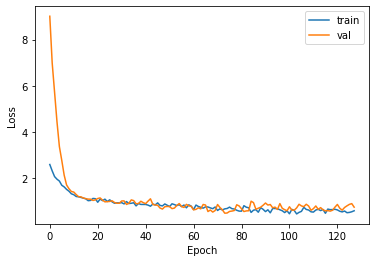

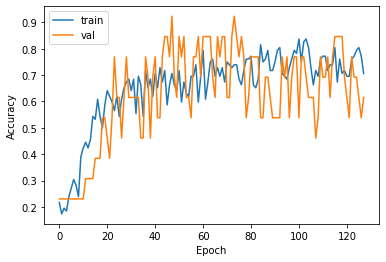

In [11]:
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.plot(hist.epoch, hist.history['accuracy'], label='train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

## Run model on test set

In [12]:
loss, acc = model.evaluate(data_test, target_test)
print(f'Test set loss: {loss:.2f}')
print(f'Test set accuracy: {100*acc:.0f}%')

1/1 [==============================] - 0s 170ms/step - loss: 0.8664 - accuracy: 0.8000
Test set loss: 0.87
Test set accuracy: 80%


## Create confusion matrix

1/1 [==============================] - 0s 117ms/step


Text(0.5, 15.0, 'Predicted label')

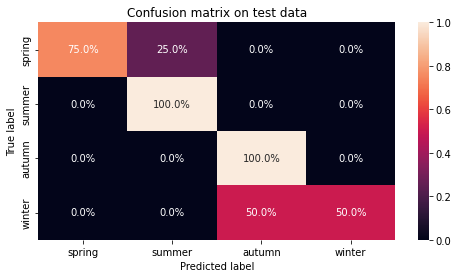

In [13]:
pred_test = model.predict(data_test)
conf_mat = confusion_matrix(target_test.to_numpy().argmax(axis=1), pred_test.argmax(axis=1), normalize='true')
plt.figure(figsize=(8, 4))
sns.heatmap(conf_mat/conf_mat.sum(axis=1), xticklabels=classes, yticklabels=classes,
            annot=True, fmt='.1%')
plt.title('Confusion matrix on test data')
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Convert model to ONNX format

In [14]:
output_file = 'weather_prediction_model.onnx'
!python -m tf2onnx.convert --keras {model_dir} --output {output_file}

/Users/loostrum/pyenv/versions/3.9.1/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/Users/loostrum/pyenv/versions/dianna/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:437: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-11-18 16:03:32,120 - WARNING - From /Users/loostrum/pyenv/versions/dianna/lib/python3.9/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future v